- Generate internal and boundary collocation points 
- since the problem is small, try automatic differentiation 
- Automatic differentiation didnt work, try symbolic approach 


In [1]:
using BenchmarkTools
using ForwardDiff
include("RBFunctions.jl")
using Plots
using Symbolics
using Latexify

In [2]:
@variables ϵ r x₁ x₂;

ϕ = exp(-r^2*ϵ^2)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2))    #sqrt(x₁^2 + x₂^2)
display(ϕ)

Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = expand_derivatives(Differential(x₁)(exprs))
∂₂(exprs) = expand_derivatives(Differential(x₂)(exprs))

a11 = -∂₂(∂₂(Δ(Δ(ϕ)))) - ∂₁(∂₁(ϕ))
a12 =  ∂₁(∂₂(Δ(Δ(ϕ)))) - ∂₁(∂₂(ϕ))
a13 =  ∂₂(∂₂(Δ(ϕ)))
a14 = -∂₁(∂₂(Δ(ϕ)))
a22 = -∂₁(∂₁(Δ(Δ(ϕ)))) - ∂₂(∂₂(ϕ))
a23 = -∂₁(∂₂(Δ(ϕ)))
a24 =  ∂₁(∂₁(Δ(ϕ)))
a33 = -∂₂(∂₂(ϕ))
a34 =  ∂₁(∂₂(ϕ))
a44 = -∂₁(∂₁(ϕ))

b11 =  ∂₂(∂₂(Δ(ϕ)))
b12 = -∂₁(∂₂(Δ(ϕ)))
b13 = -∂₂(∂₂(ϕ))
b14 =  ∂₁(∂₂(ϕ))
b21 = -∂₁(∂₂(Δ(ϕ)))
b22 =  ∂₁(∂₁(Δ(ϕ)))
b23 =  ∂₁(∂₂(ϕ))
b24 = -∂₁(∂₁(ϕ))
b31 = -∂₁(ϕ)
b32 = -∂₂(ϕ)
display(a44)
expression_list = [a11,a12,a13,a14,a22,a23,a24,a33,a34,a44]
eval_expression_list = [b11,b12,b13,b14,b21,b22,b23,b24,b31,b32]
function_list = []
eval_function_list =[]
for exprs in expression_list
    ee = build_function(exprs, [x₁, x₂], ϵ)
    append!(function_list,[eval(ee)])
end
for exprs in eval_expression_list
    ee = build_function(exprs, [x₁, x₂], ϵ)
    append!(eval_function_list,[eval(ee)])
end


function_list[1]([0.5,0],2.3)

exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))

(2//1)*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (4//1)*(x₁^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))

-239.41752984541108

In [3]:


function RBF_evaluate(eval_points,domain_p,boundary_p,coefficients,f_list,param)
    T_ed = point_difference_tensor(eval_points,domain_p)
    T_eb = point_difference_tensor(eval_points,boundary_p)
    a1,a2,a3 = size(T_eb)
    b11,b12,b13,b14,b21,b22,b23,b24,b31,b32 = f_list
    B11 =  apply(b11,T_ed,param)
    B12 =  apply(b12,T_ed,param)
    B13 =  apply(b13,T_eb,param)
    B14 =  apply(b14,T_eb,param)

    B21 =  apply(b21,T_ed,param)
    B22 =  apply(b22,T_ed,param)
    B23 =  apply(b23,T_eb,param)
    B24 =  apply(b24,T_eb,param)

    B31 = apply(b31,T_ed,param)
    B32 = apply(b32,T_ed,param)
    B33 = zeros((a1,a2))
    B34 = zeros((a1,a2))

    output = zeros((3,size(eval_points)[2]))
    output[1,:] = [B11 B12 B13 B14] * coefficients
    output[2,:] = [B21 B22 B23 B24] * coefficients
    output[3,:] = [B31 B32 B33 B34] * coefficients
    #display(output)
    return output
end

function true_velocity(x,y)
    return [20*x*y^3  5*x^4 - 5*y^4]
end
function true_pressure(x,y)
    return 60*x*x*y - 20*y^3 
end



true_pressure (generic function with 1 method)

1.0


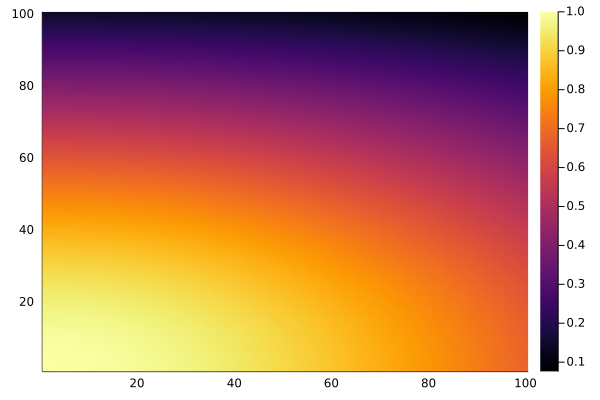

In [4]:
ZZ  =200
tst1 = [function_list[7]([i,j],0.5) for i=LinRange(0,1,100),j=LinRange(0,1,100) ]

println(maximum(tst1))
heatmap(tst1)


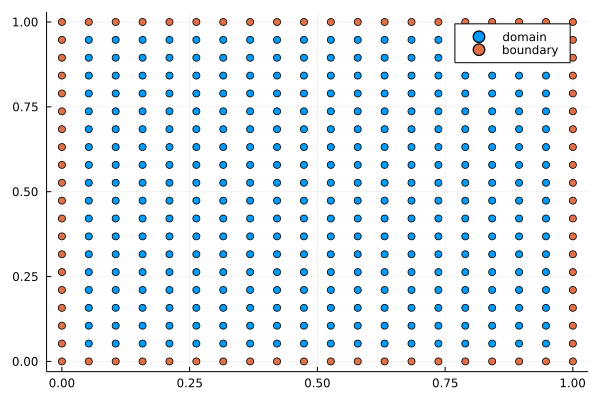

In [5]:
# generate points 
include("RBFunctions.jl")
domain_p, boundary_p = generate_2D_equally_spaced_points(20)
N_domain = size(domain_p)[2]
N_boundary = size(boundary_p)[2]
all_points = [domain_p boundary_p]
scatter(domain_p[1,:],domain_p[2,:],label="domain")
scatter!(boundary_p[1,:],boundary_p[2,:],label="boundary")



In [9]:
T_dd = point_difference_tensor(domain_p,domain_p)
T_db = point_difference_tensor(domain_p,boundary_p)
T_bb = point_difference_tensor(boundary_p,boundary_p)
param = 5
f11,f12,f13,f14,f22,f23,f24,f33,f34,f44 = function_list
A11 = apply(f11,T_dd,param)
A12 = apply(f12,T_dd,param)
A13 = apply(f13,T_db,param)
A14 = apply(f14,T_db,param)
A22 = apply(f22,T_dd,param)
A23 = apply(f23,T_db,param)
A24 = apply(f24,T_db,param)
A33 = apply(f33,T_bb,param)
A34 = apply(f34,T_bb,param)
A44 = apply(f44,T_bb,param)
A = [A11  A12  A13  A14
    A12' A22  A23  A24
    A13' A23' A33  A34
    A14' A24' A34' A44]
#A = Symmetric(A)
println("condition number of A: ",cond(A))
println("max element of A: ", maximum(A))
println("size of A: ", size(A))
g = [true_velocity(boundary_p[1,i],boundary_p[2,i])[j] for j = 1:2 , i=1:size(boundary_p)[2]]
F = zeros(size(domain_p)[2]*2)
F = vcat(F,g[1,:],g[2,:])
coef = A\F
println("finished", coef)
p1 = heatmap(A[180:end,180:end])
plot(p1, size =(700,600))
#display(A[1:20,1:20])
J = Diagonal(diag(A))
#cond(inv(A-J)*A)

condition number of A: 2.262093380967081e20
max element of A: 3.00005e6
size of A: (800, 800)
finished[67.66167491704931, -168.05369021240054, 298.77196888425436, -370.5577216048307, 440.55813622276753, -730.8156218623113, 1576.9150962766955, -3035.6850008907486, 4728.6633589802705, -5858.283551429485, 5780.937893859623, -4428.6377810971435, 2487.5713103121325, -822.7025493436627, -51.12477195273361, 264.82405475689694, -186.71966801856402, 86.76334245398971, -404.37778981503544, 1190.9438882888103, -2368.4948612127214, 3123.142858593878, -2993.4115110111447, 1865.580043380666, -662.6420055642492, 854.2721864092072, -4054.0243119413817, 10045.563852108184, -16389.869736315846, 19204.479763975814, -16503.702623960686, 9700.515055071515, -2902.566025138436, -819.8306813316055, 1283.6374909126796, -555.0609546846123, 1205.1753625326335, -3370.5835392360714, 6353.492067360877, -8085.08052866071, 7691.323246657146, -4112.878858588287, -1822.9196892087664, 6992.090885749435, -4846.8428568034

800×800 Diagonal{Float64, Vector{Float64}}:
 3.00005e6   ⋅          ⋅         …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅         3.00005e6   ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅         3.00005e6       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅         …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅         …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
  ⋅          ⋅          ⋅              ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 ⋮                  

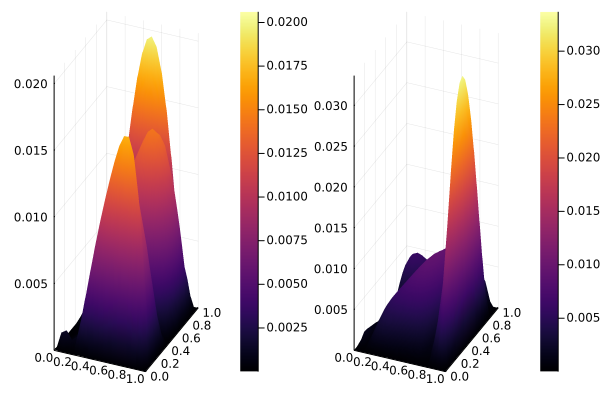

In [7]:
numerical_solution = RBF_evaluate(all_points,domain_p,boundary_p,coef,eval_function_list,param)

true_solution = [true_velocity(all_points[1,i],all_points[2,i])[j] for j = 1:2 , i=1:size(all_points)[2]]

p1 = surface(all_points[1,:],all_points[2,:],abs.(true_solution[1,:] - numerical_solution[1,:]))
p2 = surface(all_points[1,:],all_points[2,:],abs.(true_solution[2,:] - numerical_solution[2,:]))
#print(numerical_solution)
plot(p1, p2, layout=(1,2), legend=false)

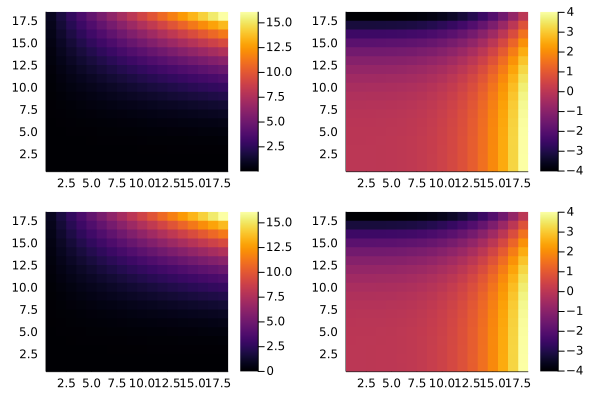

In [8]:
bbb = floor(Int64,sqrt(N_domain))
true1 = permutedims(reshape(true_solution[1,1:N_domain],(bbb,bbb)),(1,2))
true2 = permutedims(reshape(true_solution[2,1:N_domain],(bbb,bbb)),(1,2))
numerical1 = permutedims(reshape(numerical_solution[1,1:N_domain],(bbb,bbb)),(1,2))
numerical2 = permutedims(reshape(numerical_solution[2,1:N_domain],(bbb,bbb)),(1,2))
p1 = heatmap(true1)
p2 = heatmap(true2)
p3 = heatmap(numerical1)
p4 = heatmap(numerical2)
plot(p1, p2, p3, p4, layout=(2,2), legend=false)